In [1]:
import time
from copy import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as it
import scipy as sp
from scipy.signal import convolve2d
from scipy.ndimage import rotate
from skimage.draw import circle


# Custom modules
from lib.myhelpers import sin, cos, tan, pi, sign
from lib.envmap import Map, Rect

In [2]:
GRID_RES  = 2 # 2x2 grid resolution
ANGLE_RES = 5 # 5 degree angle resolution

ROBOT_DIMS = np.array([50,50]) # robot is 50 x 50 square

# Map dimensions
xlim = (0,800)
ylim = (0,300)

map_width  = np.diff(xlim)
map_height = np.diff(ylim)

# Define map
env = Map(origin=(0,0), 
          xlim=xlim, 
          ylim=ylim, 
          resolution=GRID_RES, 
          lefthanded=True) # arraylike indiates dimensions are left-handed

obstacles = [
    # Outer borders - start and endpoints
    [(0,0),(800,0)],
    [(0,0),(0,300)],
    [(800,0),(800,300)],
    [(0,300),(800,300)],
    # Inner borders
    [(200,0),(200,200)],
    [(100,200),(300,200)],
    [(400,300),(400,100)],
    [(600,0),(600,200)],
    [(500,200),(700,200)]
]

[env.draw_line(*o) for o in obstacles];



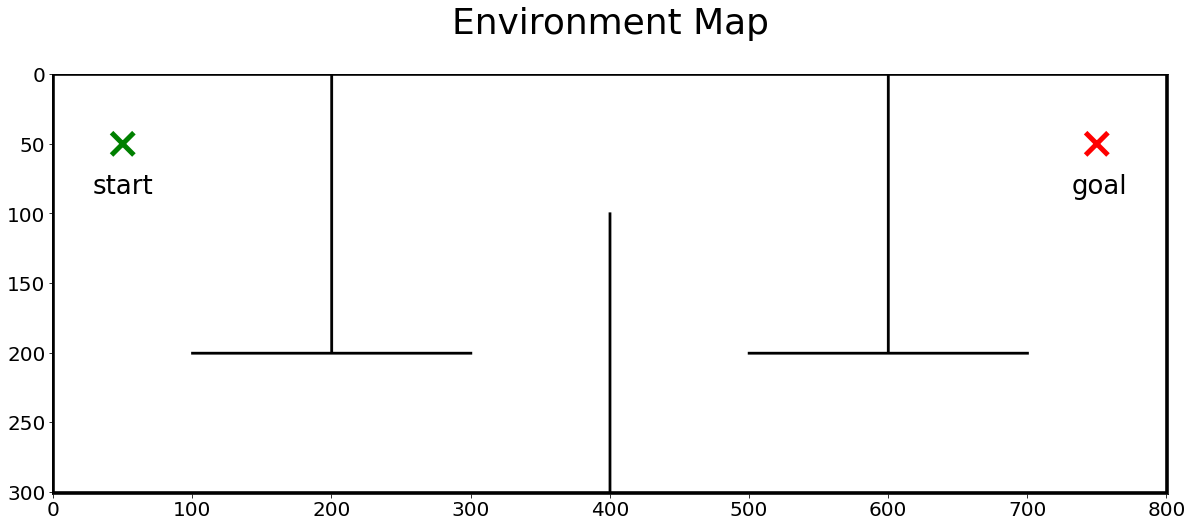

In [3]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='white')

# Plot environment
scaled_grid = np.kron(env.grid, np.ones((GRID_RES,GRID_RES), dtype=env.grid.dtype)) # Inflate so each grid square is 2x2 pixels
ax.imshow(scaled_grid, cmap='gray_r')
# Plot start and end points with x markers
start = np.array([50,50])
end = np.array([750,50])
plt.scatter(x=[start[0],end[0]], y=[start[1],end[1]], 
            marker='x', c=['g','r'], s=500, linewidth=5)

# Formatting
plt.title('Environment Map', fontsize=36, pad=40)
ax.tick_params(axis='both', labelsize=20)
ax.annotate(xy=start, xytext=[-30,-50], textcoords='offset points',
             text='start', fontsize=26)
ax.annotate(xy=end, xytext=[-25,-50], textcoords='offset points',
             text='goal', fontsize=26);

To determine the free configuration space of the robot at each orientation, we can first find the complement of the freespace by convolving the robot at each orientation with the environmental grid. Any resulting point with a nonzero value represents nonzero overlap between the robot and a wall, and therefore an invalid configuration.

In [4]:
# The configuration space will be a 3D array where the first two dimensions are those of
# env_grid, and the third dimension spans the angle space.
# NOTE: A square has rotational symmetry of order 4 -> therefore, we only need to consider 
# rotations (in degrees) mod(theta,360/4), i.e. the rotations [0,90).
orientation = np.arange(0,360//4, ANGLE_RES)
cspace = np.ones((*env.grid.shape,*orientation.shape)).astype(int)

# Create mask of robot to convolve along grid at orientation 0
robot = np.ones(ROBOT_DIMS//GRID_RES)


for i,theta in enumerate(orientation):
    # For each orientation, rotate the robot mask and convolve with the unrotated grid. 
    robot_rotated = rotate(robot,angle=theta)
    output = convolve2d(env.grid, robot_rotated, mode='same') # fillvalue=1) # fillvalue=1 to mark points outside the grid as invalid
    
    # Any nonzero square in the output corresponds to a collision/an invalid configuration.
    output[np.nonzero(output)] = 1
    
    # Store each slice in cspace array.
    cspace[...,i] = output

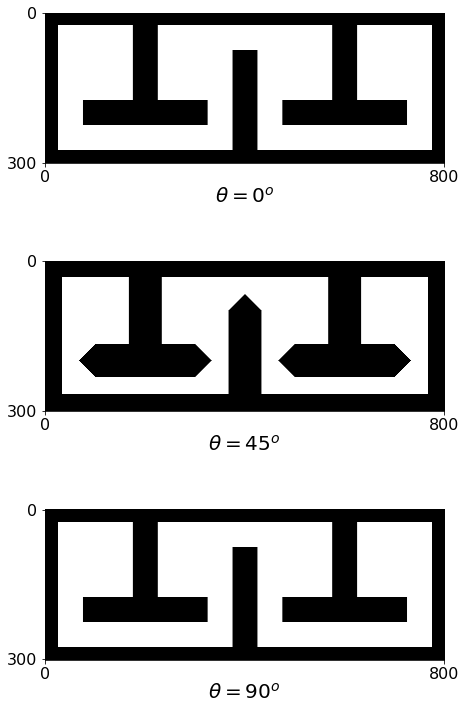

In [5]:
# Plot cspace at theta = 0, 45, 90
theta_test = [0,45,90]

fig, axes = plt.subplots(len(theta_test), figsize=(8,10), facecolor='white')
xticks = np.linspace(0,cspace.shape[1]-1,2).astype(int)
yticks = np.linspace(0,cspace.shape[0]-1,2).astype(int)
xlabels = (xticks*GRID_RES).astype(str)
ylabels = (yticks*GRID_RES).astype(str)

for ax,theta in zip(axes,theta_test):
    th = (theta % 90) // ANGLE_RES # mod 90 to account for symmetry
    ax.imshow(cspace[...,th], cmap='gray_r')
    
    # Formatting
    ax.set_title(r'$\theta={}^o$'.format(theta), y=-0.3, fontsize=20)
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(labels=xlabels, fontsize=16)
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(labels=ylabels, fontsize=16)
    

    
fig.tight_layout()
# fig.suptitle(r'$C_{{xy}}$-space at orientation$=\theta$', fontsize=22) #, pad=40)
fig.subplots_adjust(#top=0.85, 
    hspace=0.65)

## Find shortest path using greedy algorithm (Djikstra)

In [6]:
# def is_valid_config(node, fspace):
#     ''' Check that a nodes represent a valid configuration. '''
#     if np.ndim(node)==1 : # single node
#         try:
#             valid = fspace[node]
#         except IndexError:
#             valid = False
            
#     else: # list or array of nodes
#         T = type(node)
#         node = np.array(node) # make array if it isn't already

#         valid_inds = (node[:,0]<fspace.shape[0]) *  \
#                      (node[:,1]<fspace.shape[1]) *  \
#                      (node[:,2]<fspace.shape[2]) *  \
#                      ~np.any(node<0, axis=1)    

#         valid_config = [fspace[tuple(n)] for n in node]

#         valid = np.logical_and(valid_inds, valid_config)

#         if T is list:
#             valid = list(valid)

#     return valid
    

def get_valid_neighbors(node, fspace, unvisited):
    ''' 
    Return only valid neighbors of node, i.e. those that do not index beyond the 
    bounds of fspace, do not represent collisions, and that have not yet been visited.
    Note: all nodes are specified here by their indices in unvisited array.
    '''
    
    # Define an array of all valid unit moves TODO: for a differential drive robot
    heading_deg = current_node[-1] * ANGLE_RES
    dcol = np.round(cos(np.radians(heading_deg))) # estimate of a 1 unit move 
    drow = np.round(sin(np.radians(heading_deg))) # fwd in direction of heading
    
    moves = np.stack( [np.eye(3), -np.eye(3)], axis=1 ).astype(int) 
    moves = np.reshape(moves,(6,3))
    
    moves = np.array([
        [ drow, dcol,0], # how indices change when moving fwd or bkwd one unit
        [-drow,-dcol,0],
        [ 0, 0, 1], # DD robot can aways turn while still
        [ 0, 0, -1]
    ]).astype(int)
    
    # Find all neighbors of the current node by naively moving 1 unit in each direction
    naive_neighbors = node + moves

    # Drop neighbors that are out of bounds or map to collisions in config space
    neighbors = naive_neighbors[   ~np.any(naive_neighbors<0, axis=1) *  # any indices below 0
                                    (naive_neighbors[:,0]<cspace.shape[0]) *  # or above bounds
                                    (naive_neighbors[:,1]<cspace.shape[1]) *
                                    (naive_neighbors[:,2]<cspace.shape[2])
                               ]
    # Check for edge case
    assert(np.ndim(neighbors) > 1) # TODO: if after the last step only one neighbor remains, 
                                    # don't do the following list comprehensions
    
    # Keep only nodes that have not been visited and are not collisions
    neighbors = [n for n in neighbors if (unvisited[tuple(n)] and fspace[tuple(n)]) ]
    
    
    return neighbors

def find_updates(node, neighbors, cost, move_cost=1):
    ''' 
    Find the <neighbors> of <node> such that the cost of the path through <node> to
    <neighbor> is lower than the current tabulated cost at <neighbor>.
    
    The cost of the path to <neighbor> through <node> is calculated as the cost to
    <node> + move_cost.
    '''
    # Calculate new cost at each neighbor as the cost at <node> + <move_cost>
    new_cost = cost[node] + move_cost*np.ones(len(neighbors))

    # Extract old cost at each neighbor
    old_cost = [cost[tuple(n)] for n in neighbors]
    
    # Record indices of neighbors with lower new costs and the value of those new costs
    to_update = np.nanargmin( (old_cost,new_cost), axis=0).astype(bool)
    update_inds = [n for n,tu in zip(neighbors,to_update) if tu]
    update_cost = new_cost[new_cost<old_cost]
    
    return update_inds, update_cost



def get_updated_cost(node, neighbors, cost, move_cost=1):
    ''' 
    Returns the costmap where, for each <neighbor> of <node>, if the cost of the path
    to <neighbor> through <node> is lower than the current cost at <neighbor>, the cost
    at <neighbor> is updated to this new lower cost.

    The cost of the path to <neighbor> through <node> is calculated as the cost to
    <node> + move_cost.
    '''
    # Get indices where cost updates will occur and the value of those updates
    update_inds, update_cost = find_updates(node=node, neighbors=neighbors, 
                                            cost=cost, move_cost=move_cost)
    
    # Update specified costs 
    for up_ind, up_cost in zip(update_inds,update_cost):
        cost[tuple(up_ind)] = up_cost
        
    return cost

def choose_next_node(fspace, unvisited, cost):
    ''' 
    Finds the next active node based on the current costmap and set of unvisited nodes.
    The next node will be the unvisited node with the lowest current cost. 
    '''
    choice_cost = copy(cost)
    
    invalid = ~unvisited + ~fspace # mask denoting nodes that cannot be chosen
    choice_cost[invalid] = np.nan
    
    # Find the node (as indices) on <choice_cost> with the min cost
    next_node = np.unravel_index(np.nanargmin(choice_cost), choice_cost.shape)
    
    return next_node
    

In [7]:
# HERE it is more convenient to consider free configuration space <fcspace>, the inverse
# of cspace as defined above. fspace=1 where the configuration is valid, and fspace=0 
# where the configuration results in a collision. This is because we will be using
# fspace to perform logical indexing, and we want True values to represent valid configs.
fspace = ~cspace.astype(bool)


# Some parameters
N = np.product(cspace.shape) # total number of nodes in cspace (/including/ invalid nodes)
HIGHCOST = 10*N   # large cost value to represent the very large, but still finite, 
                  # initial cost estimate at eligible nodes
    
    
# Define some colormaps and how they handle NaN values
colorful = copy(mpl.cm.get_cmap('viridis'))
colorful.set_bad(color='white')

gray = copy(mpl.cm.get_cmap('gray_r'))
gray.set_bad(color='firebrick')

In [8]:
# Initialize arrays
cost = HIGHCOST*np.ones(fspace.shape) # Initialize cost array of proper size at high costs
cost[~fspace.astype(bool)] = np.nan   # Set cost of collision configurations as NaN 

unvisited = np.ones(fspace.shape).astype(bool)
# unvisited = fspace.astype(bool) # Keep track of eligible nodes we haven't visited. Mark 
#                                 # as visited by changing corresponding element to True.
#                                 # We will mark collision configurations as 'visited'
#                                 # to exclude them from searches for unvisited nodes.
    

    
# Initialize start and goal nodes, and set start node cost to 0
start_xy   = (50,50)
start_inds = (*env._to_ind(start_xy), 0) # Append start angle: theta=0 at 3rd dim index 0
cost[start_inds] = 0

goal_xy    = (750,50)
goal_inds  = tuple(env._to_ind(goal_xy)) # No specified goal angle, only position

In [9]:
# def djikstra(fspace, start, goal, iter_limit=1000):

iter_limit = N
print_mod  = iter_limit // 100
i = 0

goal_flag  = np.any(~unvisited[goal_inds])
print_flag = True

FRESH_START = True
if FRESH_START:
    current_node = tuple(start_inds)

    

#  At each loop, check if we've visited the goal and whether we've exceeded the iter_limit
while not goal_flag and i < iter_limit:
    
    ########################################################################
    # Iteration Counter Handling
    ########################################################################
    # print counter progress at multiples of print_mod
    if print_flag and i % print_mod == 0:
        print("Iteration: {}\t\t\tCurrent node: {}".format(i, current_node))
    # Increment iter counter
    i += 1

    
    ########################################################################
    # Algorithm Step
    ########################################################################
    
    # Extract list of indices representing valid unit moves through fspace
    neighbors = get_valid_neighbors(node=current_node, 
                                    fspace=fspace, 
                                    unvisited=unvisited)

    # Update costmap at neighbors if the cost through node is less than current estimate
    cost = get_updated_cost(node=current_node, 
                            neighbors=neighbors, 
                            cost=cost)

    # Mark current_node as visited
    unvisited[current_node] = False
    
    # Find unvisited node with the lowest current cost estimate; set as next current_node
    current_node = choose_next_node( fspace=fspace,    
                                     unvisited=unvisited, 
                                     cost=cost)
    
    # If goal node has been visited (at any orientation), set goalflag to True
    goal_flag = np.any(~unvisited[goal_inds])
    
    

Iteration: 0			Current node: (25, 25, 0)
Iteration: 10899			Current node: (40, 32, 10)
Iteration: 21798			Current node: (53, 35, 13)
Iteration: 32697			Current node: (55, 62, 2)
Iteration: 43596			Current node: (31, 68, 13)
Iteration: 54495			Current node: (72, 53, 12)
Iteration: 65394			Current node: (35, 83, 9)
Iteration: 76293			Current node: (84, 57, 13)
Iteration: 87192			Current node: (87, 46, 4)
Iteration: 98091			Current node: (116, 37, 15)
Iteration: 108990			Current node: (123, 31, 1)
Iteration: 119889			Current node: (128, 73, 13)
Iteration: 130788			Current node: (119, 109, 3)
Iteration: 141687			Current node: (130, 143, 6)
Iteration: 152586			Current node: (126, 164, 15)
Iteration: 163485			Current node: (107, 179, 17)
Iteration: 174384			Current node: (81, 160, 2)
Iteration: 185283			Current node: (69, 158, 3)
Iteration: 196182			Current node: (67, 128, 8)
Iteration: 207081			Current node: (54, 159, 3)
Iteration: 217980			Current node: (60, 184, 16)
Iteration: 228879			Cu

In [10]:
print('\t      i\t= ', i)
n_invalid  = np.sum(cspace)
n_eligible = np.sum(fspace)
n_visited  = np.sum(~unvisited)
print('%:','  {} / {}\t= {:.2f}% of nodes visited'
              .format(  n_visited, n_eligible, n_visited/n_eligible*100 ) )

print('{}'.format('\n   Goal reached!'*goal_flag))
print('   current_node: ', current_node)
print('      goal_node:  ({},{},{})'.format(*goal_inds,':'))

	      i	=  519665
%:   519665 / 545970	= 95.18% of nodes visited

   Goal reached!
   current_node:  (26, 316, 4)
      goal_node:  (25,375,:)


/home/aefrank/applications/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


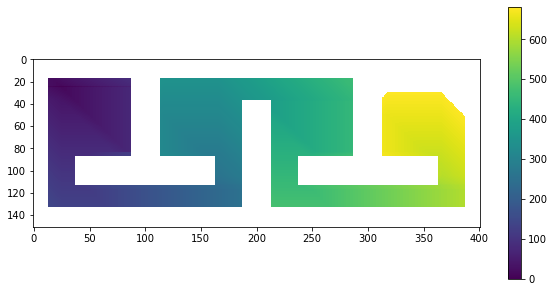

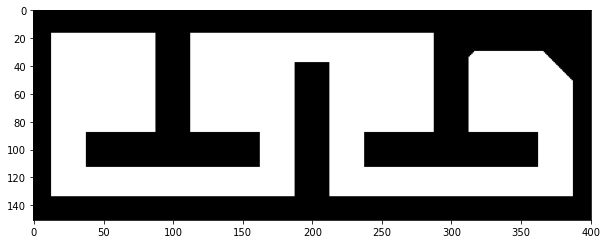

In [13]:
plt.figure(figsize=(10,5))
C = cost[...,0].astype(float)
C[unvisited[...,0]] = np.nan
# C[cspace[...,0].astype(bool)] = np.nan
im = plt.imshow(C, cmap=colorful)
ax = plt.gca()
cbar = ax.figure.colorbar(im)
plt.figure(figsize=(10,5))
plt.imshow(unvisited[...,0], cmap=gray)

In [12]:
# Save progress snapshot
goalstr = '_GOAL-REACHED'
timestr = time.strftime("%Y%m%d-%H%M%S")
np.save('data/cost_i{}_{}{}.npy'.format(i,timestr,goal_flag*goalstr),cost)
np.save('data/unvisited_i{}_{}{}.npy'.format(i,timestr,goal_flag*goalstr),unvisited)

/home/aefrank/applications/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


FileNotFoundError: [Errno 2] No such file or directory: 'snapshots/cost_i519665_20201209-190144_GOAL-REACHED.npy'

#### Stepping through greedy costmap to find shortest path

In [ ]:
cost[...,0]

In [ ]:
# Initialize path as a list of nodes (by indices) with only start node
path = [start]

# Last node in path is "current" node
path[-1] + moves


In [ ]:
heading_deg = current_node[-1] * 5
np.round(cos(np.radians(heading_deg)))

In [ ]:
sin(pi/4)